### **Librerias**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
# from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pycaret
from pmdarima import plot_acf
pd.options.display.max_rows = 20
import warnings
warnings.filterwarnings('ignore')
# Se importan las librerias necesarias para el depurado de los datos, la creacion de las graficas y analisis 

## **Etapa 0: Crear Data Set**

### PIB

In [2]:
PIB = pd.read_csv('./Datos/PIB.csv', sep=',',encoding='latin-1')
PIB = PIB[(PIB['year']>=2000) & (PIB['year']<=2020)]
PIB['year'] = PIB['year'].astype('int')
PIB['key'] = [(str((PIB.iloc[i,4])).lower()+'-'+str(PIB.iloc[i,6])) for i in range(len(PIB['country_name']))]
PIB = PIB.sort_values(by=['country_name'])
PIB.shape
# Se importa el csv con los datos de PIB, debido a que es un data-set con datos del PIB de varios años se opta por acotarlos
# a solo los ulitmos 20 años y se cambia el formato de la columna 'year' de str a int, posterios a esto se crea una llave la cual 
# toma como parametros el nombre del pais y el año para crear una llave unica para cada registro y finalmente se ordena 

(4410, 11)

### Complejidad Economica

In [3]:
Data_ECI = pd.read_csv('./Datos/ECI_Data.csv',sep=',',encoding='latin-1')
# Data_ECI = Data_ECI.transpose()
Data_ECI = Data_ECI.iloc[:,2:]
# Data_ECI = Data_ECI[2:].transpose()
Data_ECI.dropna(inplace=True)
# Se hace una transformacion del data set pues los datos del ECI van desde 1980, por lo que se hace la acotacion que 
# sea solo del 2000 al 2021, ademas se aliminan datos nulos, por lo que paises sin registro serian eliminados
# para propositos del analisis se pasa por alto la perdida de algunos datos a cambio de tener una base de 
# datos que este completa
Data_ECI.shape

(93, 24)

In [4]:
complexity = []
pais = []
año = []
for i in range(len(Data_ECI.iloc[:,:0])):
    for j in range(len(Data_ECI.iloc[0,:-3])):
        pais.append(Data_ECI.iloc[i,22])
        año.append((Data_ECI.columns[j]))
        complexity.append(Data_ECI.iloc[i,j])
ECI = pd.DataFrame()
ECI['Pais'] = pais
ECI['ECI'] = complexity
ECI['año'] = año
ECI['año'] = ECI['año'].astype('int')
ECI['key'] = [(str(ECI.iloc[i,0]).lower()+'-'+str(ECI.iloc[i,2])) for i in range(len(ECI['año']))]
ECI = ECI.sort_values(by=['Pais'])
ECI.shape
# Una vez hecho la acotacion de la base de datos, se procede a transformar el data set, primero haciendo que el pais se repita 20 veces
# en la columna pais luego en cada registro del pais se pegan los datos correspondientes al ECI y se agrega la columna de año, la cual 
# es autoincremental, este proceso se hace para pasar de registros por columnas a registros por filas. Al final se crea 
# una llave uniendo el pais y el año

(1953, 4)

### Poblacion

In [5]:
Data_Poblacion = pd.read_csv('./Datos/Poblacion_Data.csv', sep=',',encoding='latin-1')
Data_Poblacion.dropna(inplace=True)
# Se importan los datos del CSV y se eliminan aquellos registros nulos

In [6]:
Poblacion = []
pais_p = []
año = []
for i in range(len(Data_Poblacion.iloc[:,:0])):
    for j in range(len(Data_Poblacion.iloc[0,4:-2])):
        pais_p.append(Data_Poblacion.iloc[i,0])
        año.append(int(Data_Poblacion.columns[j+4]))
        Poblacion.append(Data_Poblacion.iloc[i,j+4])
Population = pd.DataFrame()
Population['Pais'] = pais_p
Population['Poblacion'] = Poblacion
Population['año'] = año
Population['key'] = [(str(Population.iloc[i,0]).lower()+'-'+str(Population.iloc[i,2])) for i in range(len(Population['año']))]
Population = Population.sort_values(by=['Pais'])
# Al igual que el ECI, se realiza ma misma transformacion: repetir el pais 20 veces en la columna pais,
# luego en cada registro del pais se pegan los datos correspondientes a la poblacion y se agrega la columna de año, la cual 
# es autoincremental. Al final se crea una llave uniendo el pais y el año

### Region

In [7]:
cordenada = pd.read_csv('./Datos/country-coord.csv', sep=',',encoding='latin-1')
cordenada['country'] = [(str(cordenada.iloc[i,0]).lower()) for i in range(len(cordenada['Country']))]
cordenada.dtypes
# Se importa la data csv y se crea una nueva columna llamada "country", la cual simplemente
# el el nombre de los paises pero en minusculas

Country       object
Latitude     float64
Longitude    float64
country       object
dtype: object

In [8]:
cordenada['Ecuador'] = [1 if cordenada.iloc[i,1]<=27 and cordenada.iloc[i,1]>=-27 else 0 for i in range(len(cordenada['country']))]
# Se crea la columna Ecuador, por medio de un list comprehension el cual asigna valores de 1 o 0 dependiendo del valor de las latitudes de cada pais
# tomando con 1 aquellos paises que estan dentro de la zona tropical y 0 aquellos que esten mas al norte o sur del planeta

### Union DataFrames

In [9]:
Data_final = PIB.merge(Population,left_on='key',right_on='key').merge(ECI,left_on='key',right_on='key')
Data_final = Data_final[['Pais_x', 'Poblacion', 'total_gdp_million','ECI','año_x']]
Data_final['country'] = [(str(Data_final.iloc[i,0]).lower()) for i in range(len(Data_final['Pais_x']))]
Data_final = pd.merge(Data_final, cordenada, on ='country', how ='inner')
Data_final = Data_final[['Pais_x', 'Poblacion', 'total_gdp_million','ECI','año_x','Ecuador']]
Data_final.to_csv('Datos/Crecimiento_ec.csv')
# Se unen los diferentes dataframes antes creados, con el fin de que los datos conserven su estructura y evitar que un dato de la  
# poblacion de un pais se asigne a otro, se unen los diferentes dataframes por medio de las 'Key' la cual fue creada 
# en cada uno de los dataframes, excepto por las cordenadas. En este caso la llave era el mismo nombre del pais, por lo que 
# simplemente se hizo la union entre del df-coordenada y el df-data_final con la columna 'country' como llave para unir los df

## **Etapa 1: Entender los Datos**

In [10]:
Data = pd.read_csv('./Datos/Crecimiento_ec.csv')
Data.drop('Unnamed: 0',axis=1,inplace=True)
Data['año'] = ["".join([str(Data.iloc[i,4]),"-01"]) for i in range(len(Data.año_x))]
# Se crea una nueva columna la cual es 'año', la que es un string que une año_x y "01", esto porque posteriormente se 
# transformara este string en un formato fecha

In [11]:
Data.info()
# Se obtiene la informacion del Dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1575 entries, 0 to 1574
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Pais_x             1575 non-null   object 
 1   Poblacion          1575 non-null   float64
 2   total_gdp_million  1575 non-null   float64
 3   ECI                1575 non-null   float64
 4   año_x              1575 non-null   int64  
 5   Ecuador            1575 non-null   int64  
 6   año                1575 non-null   object 
dtypes: float64(3), int64(2), object(2)
memory usage: 86.3+ KB


In [12]:
def timeline(columna):
    time = pd.pivot_table(Data,values=columna,columns=['año_x'],aggfunc='mean')
    return time
# Esta funcion se encarga de recibir una columnana del Dataset y convertirla en una pivot-tabble, en la cual se agrupan 
# a los paises y el parametro del columna promediando los valores de dicho parametro

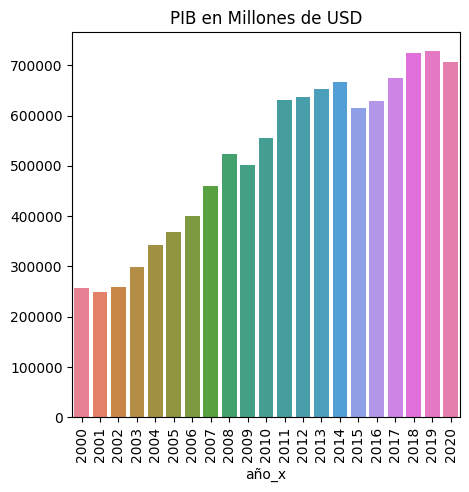

In [13]:
fig,ax = plt.subplots(1,sharex=True,figsize=(5,5))
ax = sns.barplot(timeline('total_gdp_million'))
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('PIB en Millones de USD')
plt.show()
# Usando la funcion creada antes, se para como parametro el 'total_gdp_million' y a partir de ese dataframe auxiliar 
# se crea una grafica que muestra la evolucion del PIB a los largo de los años

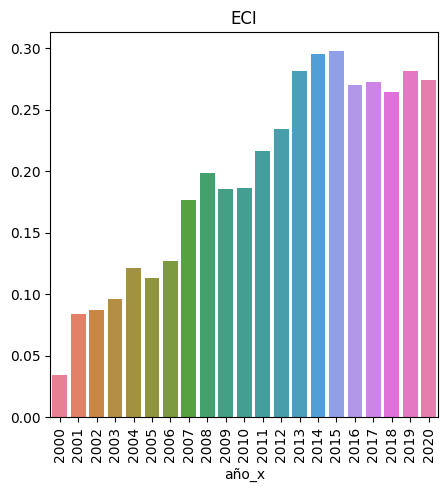

In [14]:
fig,ax = plt.subplots(1,sharex=True,figsize=(5,5))
ax = sns.barplot(timeline('ECI'))
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('ECI')
plt.show()
# Usando la funcion creada antes, se para como parametro el 'ECI' y a partir de ese dataframe auxiliar 
# se crea una grafica que muestra la evolucion del ECI a los largo de los años

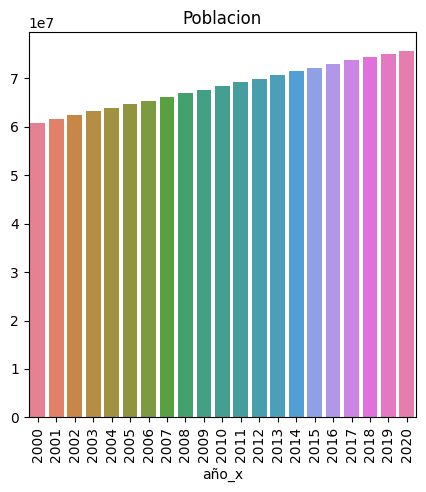

In [15]:
fig,ax = plt.subplots(1,sharex=True,figsize=(5, 5))
ax = sns.barplot(timeline('Poblacion'))
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('Poblacion')
plt.show()
# Usando la funcion creada antes, se para como parametro el 'Poblacion' y a partir de ese dataframe auxiliar 
# se crea una grafica que muestra la evolucion de la Poblacion a los largo de los años

## **Etapa 2: Revisar problemas en Series de Tiempo**

In [16]:
X = Data[['Poblacion', 'ECI', 'año_x', 'Ecuador']]
Y = Data['total_gdp_million']
# Se hace la division de los datos, X siendo las variables independtientes y Y siendo la variables 
# dependiente

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)
# Se hace una division de los datos para test y para train

### ***Revisar Multicolinealidad***

In [18]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
variables = Data_final.drop(columns=['Pais_x'])
vif_data = pd.DataFrame()
vif_data["Variable"] = variables.columns
vif_data["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
# Se empieza con una prueba de multicolineadlidad, estco con el fin de determinar si las variables sean independientes entre si.
# Para de este modo poder garantizar que las variables elegidas aportan informacion relevante para el modelo

In [19]:
print("\nVIF:")
print(vif_data)
# Se imprimen los datos del VIF


VIF:
            Variable       VIF
0          Poblacion  1.781558
1  total_gdp_million  2.157813
2                ECI  1.609753
3              año_x  2.499387
4            Ecuador  2.434782


Existe multicolinealidad leve entre los datos entre los datos, por lo que no necesariamente se debe eliminarla pues al ser una multicolinalidad moderada el modelo de regresion lineal puede seguir haciendo predicciones de manera correcta

### ***Revisar Autocorrelacion***

In [20]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.graphics import tsaplots
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import adfuller
# Se importan las librerias para evaluar si hay autocorrelacion entre las variables
# pues al tratarse de series de tiempo este es un problemas bastante comun en este tipo de datasets

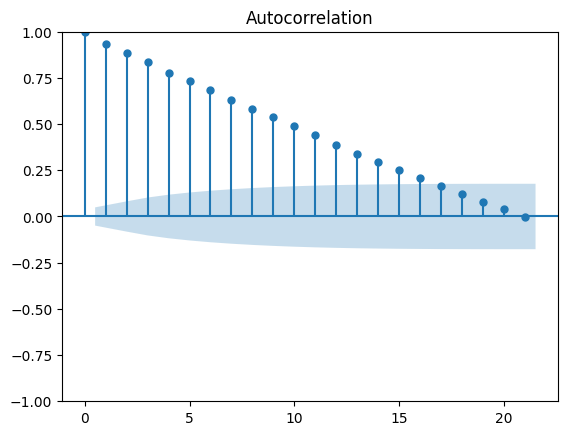

In [21]:
X = np.array(Data_final.ECI)
sm.tsa.acf (X)
fig = tsaplots.plot_acf(X,lags=21)
plt.show ()
# Se define un X, siento este la columna con la informacion del ECI (Complejidad economica) y se grafica 
# el comportamiento de su autocorrelacion 

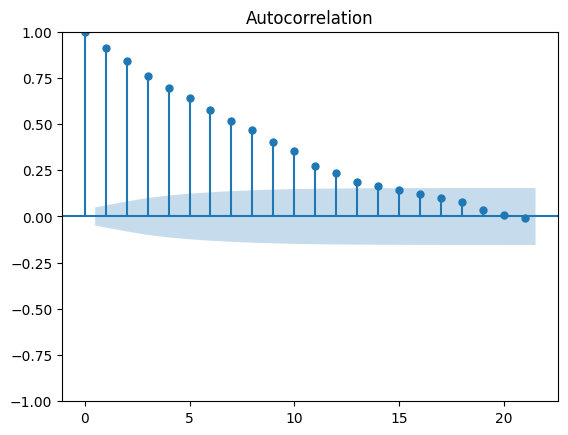

In [22]:
X = np.array(Data_final.total_gdp_million)
sm.tsa.acf (X)
fig = tsaplots.plot_acf(X,lags=21)
plt.show ()
# Se define un X, siento este la columna con la informacion del PIB y se grafica 
# el comportamiento de su autocorrelacion 

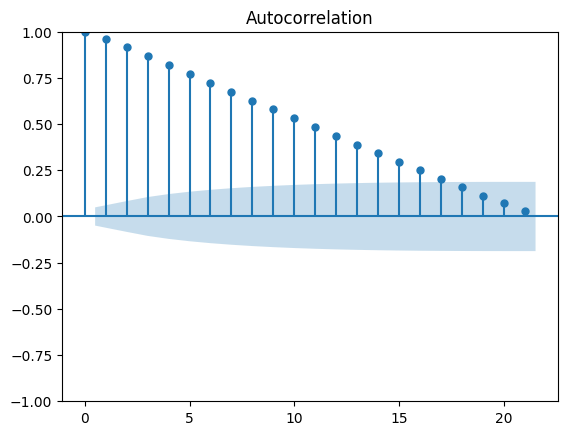

In [23]:
X = np.array(Data_final.Poblacion)
sm.tsa.acf (X)
fig = tsaplots.plot_acf(X,lags=21)
plt.show ()
# Se define un X, siento este la columna con la informacion de la poblacion y se grafica 
# el comportamiento de su autocorrelacion 

In [24]:
model_1 = ols('total_gdp_million ~ Poblacion + ECI + Ecuador', data=Data_final).fit()
durbin_watson(model_1.resid)
# Se hace la prueba de autocorrelacion de Durbin-Watson usando un modelos en el que el PIB depende del ECI
# la poblacion y Ecuador (posicion geografica respecto a la zona tropical)

0.28431927577944044

In [25]:
model_2 = ols('total_gdp_million ~ Poblacion + Ecuador ', data=Data_final).fit()
durbin_watson(model_2.resid)
# Se hace la prueba de autocorrelacion de Durbin-Watson usando un modelos en el que el PIB depende de
# la poblacion y Ecuador (posicion geografica respecto a la zona tropical)

0.273151820843164

In [26]:
model_3 = ols('total_gdp_million ~ ECI + Poblacion ', data=Data_final).fit()
durbin_watson(model_3.resid)
# Se hace la prueba de autocorrelacion de Durbin-Watson usando un modelos en el que el PIB depende del ECI
# y la poblacion

0.2823922478876901

* En este caso se observa que los modelos muestra autocorrelacion pues se trata de Datos de panel los cuales tienen una componente temporal, en este caso la prueba de DurbiWatson para los 3 modelos arroja el valor de ***ρ*** cercado a 0 [0.28,0.27,0.28] entrando en el rango de 0<***ρ***<1 dando un DW = 2 (Durbin Watson) dando como resultado que el dataset tiene autocorrelacion positiva , lo que se refuerza al ver la grafica la cual solo en el rezago 21 tiene autocorrelacion de 0, mietras que a lo largo de la grafica siempre se observo que la autocorrelacion fue bajando pocco a poco.

* El problema de que exista autocorrelacion es que el modelo al usar regresion lineal tendra problemas a la hora ajsutar el modelo pues puede generar un Coeficiente de Determinacion muy perfecto R<sup>2</sup>=1, lo que haria que existe overfitting en el modelo imposibilidanto la generalizacion de los datos.


### ***Revisar Estacionariedad***

In [27]:
import plotly.express as px
Data_glob = pd.pivot_table(Data,index='año',values=['total_gdp_million','Poblacion','ECI'],aggfunc='sum').reset_index()
Data_glob['Time'] = pd.to_datetime(Data_glob['año'])
Data_glob = Data_glob.sort_values(by='Time')
fig = px.line(Data_glob, x="Time", y=["total_gdp_million"], template = 'plotly_dark')
fig.show()
# Se crea una nueva variables que es Data_glob, la cual resume el comportamiento de todos los paises a lo largo de los años
# usando una Pivot-Table, luego se crea la columna "Time", la cual depende de la columna año que fue creada anteriormente (es la concatenacion de año_x + "-01")
# para de este modo tener una variable temporal, se ordenan los valores por la columna "Time" y se realiza la grafica
# La grafica se hace con el fin de ver com es el comportamiento general de los paises a lo largo del tiempo

In [28]:
D_fuller = adfuller(Data_glob.total_gdp_million,autolag='AIC')
print(f'El Estadistico D-Fuller es: {D_fuller[0]}')
print(f'El p-valor es de: {D_fuller[1]}. No rechazo H0, por lo que la serie para el PIB tiene comportamiento NO Estacional')
# Para la columna "total_gdp_million" se hace la prueba de estacionariedad de Dickey Fuller, esta lo que busca es 
# ver si un conjunto de datos tiene o no un comportamiento estacional, de esta forma se vuelve a confirmar 
# que existe autocorrelacion y que los datos no tienen una media constante, sino que esta cambia con el tiempo

El Estadistico D-Fuller es: -1.1793378898436007
El p-valor es de: 0.6824202844756092. No rechazo H0, por lo que la serie para el PIB tiene comportamiento NO Estacional


In [29]:
D_fuller = adfuller(Data_glob.Poblacion,autolag='AIC')
print(f'El Estadistico D-Fuller es: {D_fuller[0]}')
print(f'El p-valor es de: {D_fuller[1]}. rechazo H0, por lo que la serie para la Poblacion es Estacional')
# Para la columna "Poblacion" se hace la prueba de estacionariedad de Dickey Fuller, esta lo que busca es 
# ver si un conjunto de datos tiene o no un comportamiento estacional, de esta forma se vuelve a confirmar 
# que existe autocorrelacion y que los datos no tienen una media constante, sino que esta cambia con el tiempo

El Estadistico D-Fuller es: -2.964283780870511
El p-valor es de: 0.03836715950778153. rechazo H0, por lo que la serie para la Poblacion es Estacional


In [30]:
D_fuller = adfuller(Data_glob.ECI,autolag='AIC')
print(f'El Estadistico D-Fuller es: {D_fuller[0]}')
print(f'El p-valor es de: {D_fuller[1]}. No rechazo H0, por lo que la serie tiene comportamiento NO Estacional')
# Para la columna "ECI" se hace la prueba de estacionariedad de Dickey Fuller, esta lo que busca es 
# ver si un conjunto de datos tiene o no un comportamiento estacional, de esta forma se vuelve a confirmar 
# que existe autocorrelacion y que los datos no tienen una media constante, sino que esta cambia con el tiempo

El Estadistico D-Fuller es: -1.1553311905910721
El p-valor es de: 0.6925101184130171. No rechazo H0, por lo que la serie tiene comportamiento NO Estacional


El valor de p > 0.05 NO rechaza la hipotesis Nula, por lo que se puede decir que la serie de tiempo NO tiene un comportamiento estacional

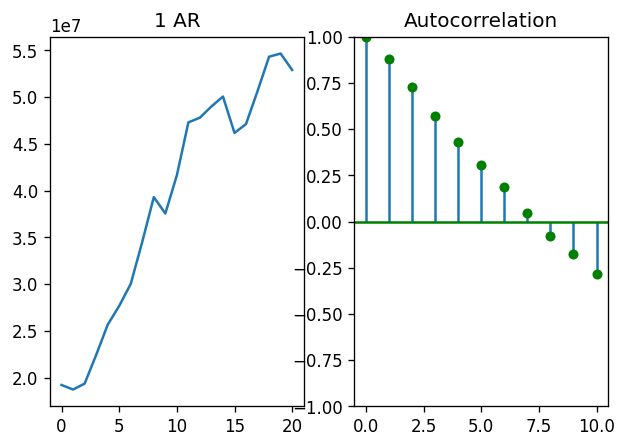

In [31]:
plt.rcParams.update({'figure.figsize':(6,4), 'figure.dpi':120})
fig,axes = plt.subplots(1,2)
axes[0].plot(Data_glob.total_gdp_million);axes[0].set_title('1 AR')
plot_acf(Data_glob.total_gdp_million,ax=axes[1],color='g')
# Se hace un grafico que muestra el comportamiento de el "total_gdp_million" tanto su estacionariedad como su 
# autocorrelacion

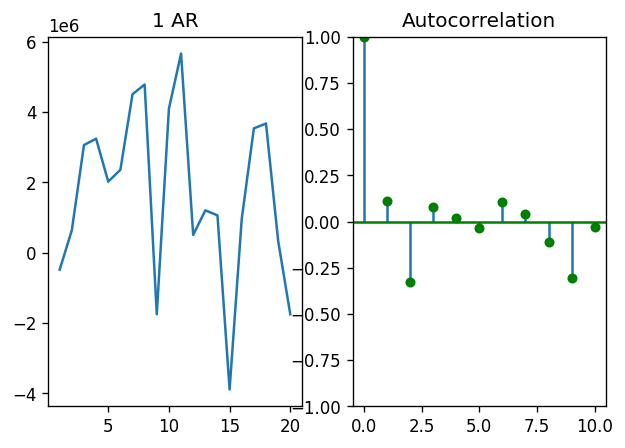

In [32]:
plt.rcParams.update({'figure.figsize':(6,4), 'figure.dpi':120})
fig,axes = plt.subplots(1,2)
axes[0].plot(Data_glob.total_gdp_million.diff());axes[0].set_title('1 AR')
plot_acf(Data_glob.total_gdp_million.diff().dropna(),ax=axes[1],color='g')
# Se hace un grafico que muestra el comportamiento de el "total_gdp_million" tanto su estacionariedad como su 
# autocorrelacion, despues de una diferencia, es decir hacer 1 rezago

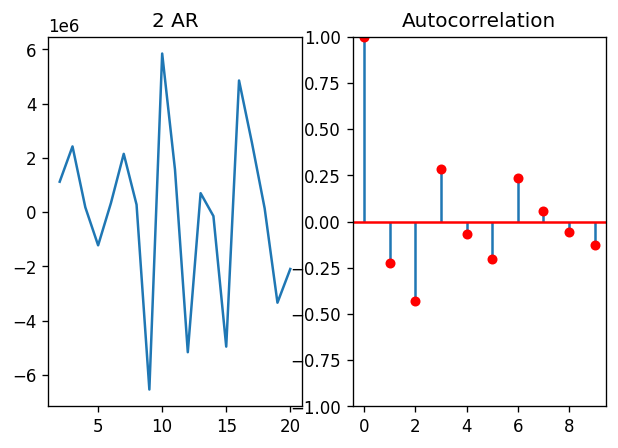

In [33]:
plt.rcParams.update({'figure.figsize':(6,4), 'figure.dpi':120})
fig,axes = plt.subplots(1,2)
axes[0].plot(Data_glob.total_gdp_million.diff().diff());axes[00].set_title('2 AR')
plot_acf(Data_glob.total_gdp_million.diff().diff().dropna(),ax=axes[1],color='r')
# Se hace un grafico que muestra el comportamiento de el "total_gdp_million" tanto su estacionariedad como su 
# autocorrelacion, despues de dos diferencia, es decir hacer 2 rezago

### ***Eliminar Autocorrelacion y No estacionariedad***

In [34]:
def rezagos(Data,columnas,n,pais):
    A = pd.DataFrame()
    for i in range(len(columnas)):
        
        A[columnas[i]] = (Data[Data['Pais_x']==pais])[(columnas[i])].diff(periods=n).dropna()
    # A[columnas[1]] = (Data[Data['Pais_x']==pais])[(columnas[1])].diff(periods=n).dropna()
        A['Pais'] = pais
        A['Ecuador'] = Data[Data['Pais_x']==pais]['Ecuador']
        A['Poblacion'] = Data[Data['Pais_x']==pais]['Poblacion']
        A['Año'] = Data[Data['Pais_x']==pais]['año_x']
    
    return A
# Se crea una funcion que lo que hace es transfomar la serie temporal en una sin componente de tiempo por medio de
# aplicar rezagos, la funcion lo hace, es calcular nuevos datos transformando los datos por medio de 
# procesos autoregresivos una cantidad de periodos "n" la cual corresponde tambhien a la cantidad de datos
# "eliminados"

In [35]:
n =  10
pais_unico = list(set(Data_final['Pais_x']))
AUX = []
Data_no_auto = pd.DataFrame()
for x in range(len(set(Data_final['Pais_x']))):
    AUX.append(rezagos(Data_final,columnas = ['total_gdp_million','ECI'],n=n,pais=pais_unico[x]))
Data_no_auto = pd.concat(AUX,ignore_index= True)

data_glob = Data_no_auto.copy()
data_glob['Año'] = ["".join([str(data_glob.iloc[i,4]),"-01"]) for i in range(len(data_glob.Año))]
data_glob = pd.pivot_table(data_glob,index='Año',values=['total_gdp_million','Poblacion','ECI'],aggfunc='sum').reset_index()
data_glob['Time'] = pd.to_datetime(data_glob['Año'])
data_glob = data_glob.sort_values(by='Time')
fig = px.line(data_glob, x="Time", y=["total_gdp_million"], template = 'plotly_dark')
fig.show()
# Se crea un nuevo data frame el cual por medio de un ciclo for hace uso de la funion rezagos, para eliminar esa componente temporal
# en cada columna a la cual se le asigne ('total_gdp_million','ECI'), posterior a eso se crea de nuevo una columna "Año" la cual es la concatenacion
# del año + "-01", para despues pasarla a un formato de tiempo y poder hacer la grafica de como luce 
# el comportamieto del PIB sin componentes temporales

## **Etapa 3: Crear y Evaluar Modelos con Pycaret**

In [36]:
from pycaret.regression import *
from pycaret.regression import RegressionExperiment
exp = RegressionExperiment()
# Se importan las librearias de pycaret para realizar el proceso del analisis

### ***Data***

In [37]:
std = StandardScaler()
std.fit(Data_final[['total_gdp_million']])
Data_final['total_gdp_million']= std.transform(Data_final[['total_gdp_million']])
std.fit(Data_final[['Poblacion']])
Data_final['Poblacion']= std.transform(Data_final[['Poblacion']])
Data_final_2  = Data_final.drop(columns=['Pais_x'],axis=1)
# Se crea un nuevo DataFrame el el cual no se incluya el pais, para solo tener datos numericos para los analisis

In [38]:
reg = setup(Data_final_2, target = 'total_gdp_million', session_id = 123,remove_multicollinearity=False,preprocess=False)
# se configura la ruta de Pycaret para poder hacer una regresion lineal. Anteriormente se determino que la multicolinealidad
# no seria un porblema para la ejecucion de los modelos, por lo que se decide realizar una regresion lineal 
# usando simplemente la data tal cual y no remover la multicolinealidad

,Description,Value
0,Session id,123
1,Target,total_gdp_million
2,Target type,Regression
3,Original data shape,"(1575, 5)"
4,Transformed data shape,"(1575, 5)"
5,Transformed train set shape,"(1102, 5)"
6,Transformed test set shape,"(473, 5)"
7,Numeric features,4


In [39]:
best = compare_models()
# Se hace una comparacion de los diferentes modelos, dando como resultado que el regresor "Extra Trees" es el que mejor desempeño
# da a la hora de hacer un modelo de prediccion

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.0444,0.0154,0.1054,0.9853,0.0451,0.3794,0.0220
rf,Random Forest Regressor,0.0776,0.0856,0.2196,0.9183,0.0768,0.4537,0.0310
gbr,Gradient Boosting Regressor,0.1229,0.0815,0.2457,0.9133,0.1087,0.9615,0.0130
lightgbm,Light Gradient Boosting Machine,0.1106,0.1099,0.2921,0.8975,0.1007,0.7146,0.1140
dt,Decision Tree Regressor,0.0963,0.1424,0.3113,0.8301,0.1054,0.5288,0.0030
ada,AdaBoost Regressor,0.3741,0.2601,0.4837,0.6442,0.2147,2.5735,0.0090
br,Bayesian Ridge,0.4093,0.5629,0.7271,0.3295,0.2671,3.2042,0.0030
ridge,Ridge Regression,0.4098,0.5630,0.7273,0.3284,0.2671,3.2143,0.1610
lar,Least Angle Regression,0.4099,0.5631,0.7274,0.3282,0.2671,3.2167,0.0040
lr,Linear Regression,0.4099,0.5631,0.7274,0.3282,0.2671,3.2167,0.2240


In [40]:
evaluate_model(best)
# Se evalua el modelo mostando como Pycaret configura hiperparametros, calcula los residos, hace seleccion de caracteristicas etc.

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

### ***Data No Autocorrelation***

In [41]:
std = StandardScaler()
# Se importa el Scaler 

In [42]:
std.fit(Data_no_auto[['total_gdp_million']])
Data_no_auto['total_gdp_million']= std.transform(Data_no_auto[['total_gdp_million']])
std.fit(Data_no_auto[['Poblacion']])
Data_no_auto['Poblacion']= std.transform(Data_no_auto[['Poblacion']])
# Con el DataSet con sin la autocorrelacion entre datos, se hace una estandarizacion de los datos para un mejor uso de los recursos

In [43]:
train = Data_no_auto[Data_no_auto['Año'] < 2019]
test = Data_no_auto[Data_no_auto['Año'] >= 2019]
print(train.shape)
print(test.shape)
# Se hace una division de los datos entre el entreno y el test, para ello se toma como entreno los datos que esten de 2000-2018, y para el test los datos
# de 2019 y 2020

(757, 6)
(68, 6)


In [44]:
B = setup(data = train, test_data = test,target ='total_gdp_million',fold_strategy = 'timeseries',
          ignore_features=['Pais'],fold = 2, session_id = 123,
          data_split_shuffle=False,fold_shuffle=False,preprocess=False)
# se configura la ruta de Pycaret para que realice las regresiones usando series de tiempo, para de este modo
# tener resultados mas cercanos al comportamiento real de los datos

,Description,Value
0,Session id,123
1,Target,total_gdp_million
2,Target type,Regression
3,Original data shape,"(825, 6)"
4,Transformed data shape,"(825, 5)"
5,Transformed train set shape,"(757, 5)"
6,Transformed test set shape,"(68, 5)"
7,Ignore features,1
8,Numeric features,4


In [45]:
best_auto = compare_models()
# Se comparan los modelos y se tiene que K-Neighbors regressor es el que mejor puede llegar a predecir 
# el PIB de un pais segun las variables de entrada que este tenga

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.3049,1.2736,0.9363,0.2314,0.2699,1.9218,0.0600
gbr,Gradient Boosting Regressor,0.3097,1.1856,0.9129,0.2313,0.2631,2.1088,0.0400
knn,K Neighbors Regressor,0.3264,1.3434,0.9555,0.2229,0.2804,1.6978,0.0200
huber,Huber Regressor,0.3216,1.0159,0.8721,0.1713,0.2179,1.6823,0.0150
rf,Random Forest Regressor,0.3074,1.2259,0.9340,0.1701,0.2730,1.7808,0.0650
ada,AdaBoost Regressor,0.3230,1.2543,0.9465,0.1396,0.2880,1.5490,0.0300
en,Elastic Net,0.3536,1.5410,1.0193,0.1313,0.3401,2.0466,0.0100
dt,Decision Tree Regressor,0.3318,1.1730,0.9306,0.0918,0.2735,2.2441,0.0150
omp,Orthogonal Matching Pursuit,0.3816,1.5252,1.0236,0.0860,0.3338,4.0377,0.0050
llar,Lasso Least Angle Regression,0.3899,1.5714,1.0412,0.0447,0.3534,2.0098,0.0100


In [46]:
evaluate_model(best_auto)
# Se evalua el modelo mostando como Pycaret configura hiperparametros, calcula los residos, hace seleccion de caracteristicas etc.

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…